# Concise Implementation of Softmax Regression



Just as high-level deep learning frameworks
made it easier to implement linear regression
(see :numref:`sec_linear_concise`),
they are similarly convenient here.


In [4]:
using Pkg;
Pkg.activate("../../d2lai")
using d2lai, Flux, Plots

  Activating project at `/workspace/workspace/d2l-julia/d2lai`


## Defining the Model

As in :numref:`sec_linear_concise`, 
we construct our fully connected layer 
using the built-in layer. 


In [15]:
struct SoftmaxRegressionConcise{N, A} <: AbstractClassifier 
    net::N
    args::A
end
function SoftmaxRegressionConcise(net::Flux.Chain)
    SoftmaxRegressionConcise(net, nothing)
end
Flux.@layer SoftmaxRegressionConcise trainable=(net,)
d2lai.forward(model::SoftmaxRegressionConcise, x) = model.net(x)


## Softmax Revisited
:label:`subsec_softmax-implementation-revisited`

In :numref:`sec_softmax_scratch` we calculated our model's output
and applied the cross-entropy loss. While this is perfectly
reasonable mathematically, it is risky computationally, because of
numerical underflow and overflow in the exponentiation.

Recall that the softmax function computes probabilities via
$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$.
If some of the $o_k$ are very large, i.e., very positive,
then $\exp(o_k)$ might be larger than the largest number
we can have for certain data types. This is called *overflow*. Likewise,
if every argument is a very large negative number, we will get *underflow*.
For instance, single precision floating point numbers approximately
cover the range of $10^{-38}$ to $10^{38}$. As such, if the largest term in $\mathbf{o}$
lies outside the interval $[-90, 90]$, the result will not be stable.
A way round this problem is to subtract $\bar{o} \stackrel{\textrm{def}}{=} \max_k o_k$ from
all entries:

$$
\hat y_j = \frac{\exp o_j}{\sum_k \exp o_k} =
\frac{\exp(o_j - \bar{o}) \exp \bar{o}}{\sum_k \exp (o_k - \bar{o}) \exp \bar{o}} =
\frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})}.
$$

By construction we know that $o_j - \bar{o} \leq 0$ for all $j$. As such, for a $q$-class
classification problem, the denominator is contained in the interval $[1, q]$. Moreover, the
numerator never exceeds $1$, thus preventing numerical overflow. Numerical underflow only
occurs when $\exp(o_j - \bar{o})$ numerically evaluates as $0$. Nonetheless, a few steps down
the road we might find ourselves in trouble when we want to compute $\log \hat{y}_j$ as $\log 0$.
In particular, in backpropagation,
we might find ourselves faced with a screenful
of the dreaded `NaN` (Not a Number) results.

Fortunately, we are saved by the fact that
even though we are computing exponential functions,
we ultimately intend to take their log
(when calculating the cross-entropy loss).
By combining softmax and cross-entropy,
we can escape the numerical stability issues altogether. We have:

$$
\log \hat{y}_j =
\log \frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})} =
o_j - \bar{o} - \log \sum_k \exp (o_k - \bar{o}).
$$

This avoids both overflow and underflow.
We will want to keep the conventional softmax function handy
in case we ever want to evaluate the output probabilities by our model.
But instead of passing softmax probabilities into our new loss function,
we just
[**pass the logits and compute the softmax and its log
all at once inside the cross-entropy loss function,**]
which does smart things like the ["LogSumExp trick"](https://en.wikipedia.org/wiki/LogSumExp).


In [6]:
function d2lai.loss(model::SoftmaxRegressionConcise, y_pred, y)
    return Flux.crossentropy(y_pred, Flux.onehotbatch(y, 0:9))
end


## Training

Next we train our model. We use Fashion-MNIST images, flattened to 784-dimensional feature vectors.


[ Info: Train Loss: 0.95357853, Val Loss: 0.98651284, Val Acc: 0.6875
[ Info: Train Loss: 0.70093614, Val Loss: 0.7364111, Val Acc: 0.8125
[ Info: Train Loss: 0.9851046, Val Loss: 0.60898536, Val Acc: 0.8125
[ Info: Train Loss: 0.60706526, Val Loss: 0.5478655, Val Acc: 0.875
[ Info: Train Loss: 0.5998729, Val Loss: 0.5003988, Val Acc: 0.875
[ Info: Train Loss: 0.7689044, Val Loss: 0.47075206, Val Acc: 0.875
[ Info: Train Loss: 0.6330797, Val Loss: 0.44569457, Val Acc: 0.875
[ Info: Train Loss: 0.5797488, Val Loss: 0.43103746, Val Acc: 0.875
[ Info: Train Loss: 0.7476363, Val Loss: 0.41855356, Val Acc: 0.875
[ Info: Train Loss: 0.6027562, Val Loss: 0.41241825, Val Acc: 0.875


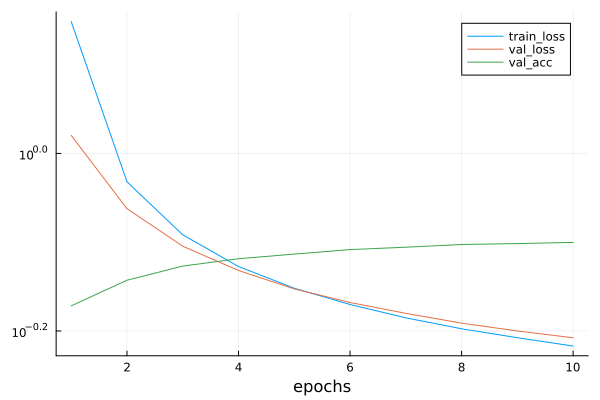

(SoftmaxRegressionConcise{Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, typeof(softmax)}}, Nothing}(Chain(Dense(784 => 10), softmax), nothing), (val_loss = Float32[0.5758142, 0.56425416, 0.68147564, 0.5907829, 0.6727967, 0.57174325, 0.5553067, 0.6133349, 0.53124404, 0.5905142  …  0.63515306, 0.6809887, 0.57906026, 0.5590671, 0.67566574, 0.6354978, 0.58995616, 0.6582454, 0.5893845, 0.41241825], val_acc = [0.81640625, 0.828125, 0.796875, 0.7890625, 0.76953125, 0.8203125, 0.8125, 0.80859375, 0.8125, 0.8046875  …  0.7890625, 0.76953125, 0.80078125, 0.83984375, 0.74609375, 0.79296875, 0.80078125, 0.79296875, 0.80078125, 0.875]))

In [16]:
net = Chain(Dense(28*28, 10), Flux.softmax)
model = SoftmaxRegressionConcise(net)
opt = Descent(0.01)
data = d2lai.FashionMNISTData(; batchsize = 256, flatten = true)
trainer = Trainer(model, data, opt; max_epochs = 10)
d2lai.fit(trainer)

As before, this algorithm converges to a solution
that is reasonably accurate,
albeit this time with fewer lines of code than before.


## Summary

High-level APIs are very convenient at hiding from their user potentially dangerous aspects, such as numerical stability. Moreover, they allow users to design models concisely with very few lines of code. This is both a blessing and a curse. The obvious benefit is that it makes things highly accessible, even to engineers who never took a single class of statistics in their life (in fact, they are part of the target audience of the book). But hiding the sharp edges also comes with a price: a disincentive to add new and different components on your own, since there is little muscle memory for doing it. Moreover, it makes it more difficult to *fix* things whenever the protective padding of
a framework fails to cover all the corner cases entirely. Again, this is due to lack of familiarity.

As such, we strongly urge you to review *both* the bare bones and the elegant versions of many of the implementations that follow. While we emphasize ease of understanding, the implementations are nonetheless usually quite performant (convolutions are the big exception here). It is our intention to allow you to build on these when you invent something new that no framework can give you.


## Exercises

1. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely),
FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.
1. INT8 is a very limited format consisting of nonzero numbers from $1$ to $255$. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?
1. Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?
1. What happens as you increase the learning rate? Compare the loss curves for several learning rates. Which one works better? When?
